<a href="https://colab.research.google.com/github/okatic/bootstrap/blob/master/Revolut_PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
hifrom google.colab import drive
drive.mount('/content/drive', force_remount=True) #mount your g drive
import pandas as pd
from IPython.display import display
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


##Load CSVs



In [0]:
path = "/content/drive/My\ Drive/Colab\ Notebooks/Oliver-revolut/" #change path to a folder on your g drive where you have stored the two csv files like /content/drive/My\ Drive/folder_containing_files


!ls $path 



doc_reports_sample.csv	face_reports_sample.csv


In [0]:
file_path = "/content/drive/My Drive/Colab Notebooks/Oliver-revolut/"  #change path to a folder on your g drive where you have stored the two csv files like /content/drive/My\ Drive/folder_containing_files/


doc_df = pd.read_csv(file_path+'doc_reports_sample.csv',index_col=0,dtype={'properties':object}).fillna('null').reset_index()
face_df = pd.read_csv(file_path+'face_reports_sample.csv',index_col=0).fillna('null').reset_index()


In [0]:
#unpack properties dict

import ast
doc_df["properties"] =  doc_df["properties"].map(lambda d : ast.literal_eval(d))
doc_df = doc_df.join(pd.DataFrame(doc_df["properties"].to_dict()).T)

##Analyze Data



In [0]:
#check doc check pass vs fail


pass_fail = pd.pivot_table(doc_df,values=['user_id'],columns=['result'],aggfunc='count')

pass_fail.head()


result,clear,consider
user_id,4406,1474


In [0]:
#join csv files into single dataframe

joined =pd.merge(face_df, doc_df, on='user_id', how='outer')
joined.rename(index=str, columns={"result_x": "face_result", "result_y": "doc_result"},inplace=True)

In [0]:
#check doc check pass vs fail for both checks

pass_fail = pd.pivot_table(joined,values=['user_id'],index=['doc_result','face_result'],aggfunc='count')

pass_fail.rename(index=str, columns={"user_id": "user_count"},inplace=True)

pass_fail


user_count
doc_result face_result            
clear      clear              4256
           consider            177
consider   clear              1314
           consider            197

Doc check seems to be causing most of the issues, let's drill down into more specific areas of concern for Doc check

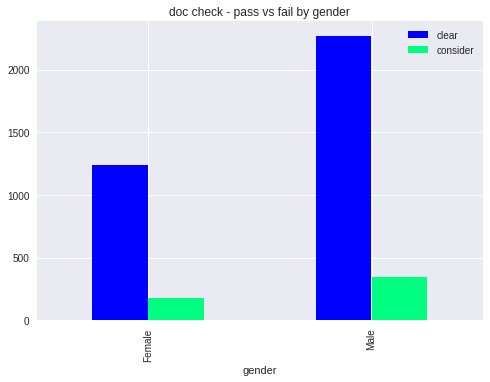

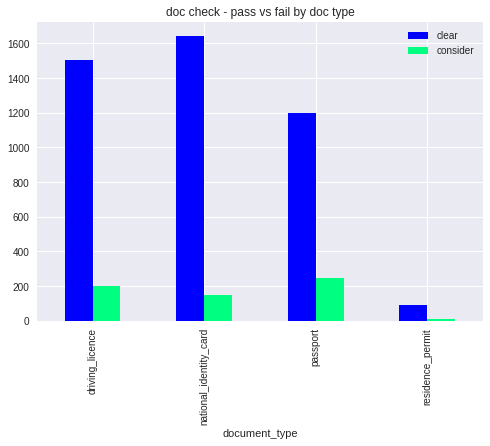

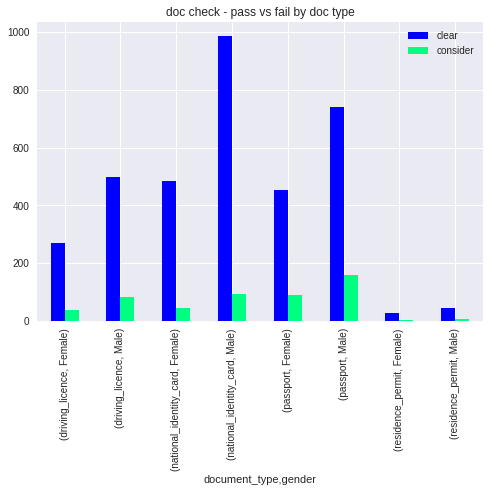

In [0]:
def remove_multiindex(df):

  df.columns = df.columns.droplevel(0)

  df = df.rename_axis(None, axis=1)
  
  return df


gender = pd.pivot_table(joined,values=['user_id'],columns=['doc_result'],index='gender',aggfunc='count')
remove_multiindex(gender).plot(kind='bar',colormap='winter',title='doc check - pass vs fail by gender')

doc_type = pd.pivot_table(joined,columns=['doc_result'],values=['user_id'],index=['document_type'],aggfunc='count')

remove_multiindex(doc_type).plot(kind='bar',colormap='winter',title='doc check - pass vs fail by doc type')

doc_type_gen = pd.pivot_table(joined,columns=['doc_result'],values=['user_id'],index=['document_type','gender'],aggfunc='count')

remove_multiindex(doc_type_gen).plot(kind='bar',colormap='winter',title='doc check - pass vs fail by doc type')

doc_type_gen = pd.pivot_table(joined,columns=['doc_result'],values=['user_id'],index=['document_type','issuing'],aggfunc='count')


Let's change to percentage to make for easier comparison





In [0]:
def get_pass_rate(df):


  df['total']= df['clear']+df['consider']
  df['pass_rate'] =df['clear']/df['total']
  new_df = df.drop(columns=['clear','consider','total'])
  

  return new_df

get_pass_rate(gender)


gen_pass_rate =get_pass_rate(doc_type_gen).reset_index()


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


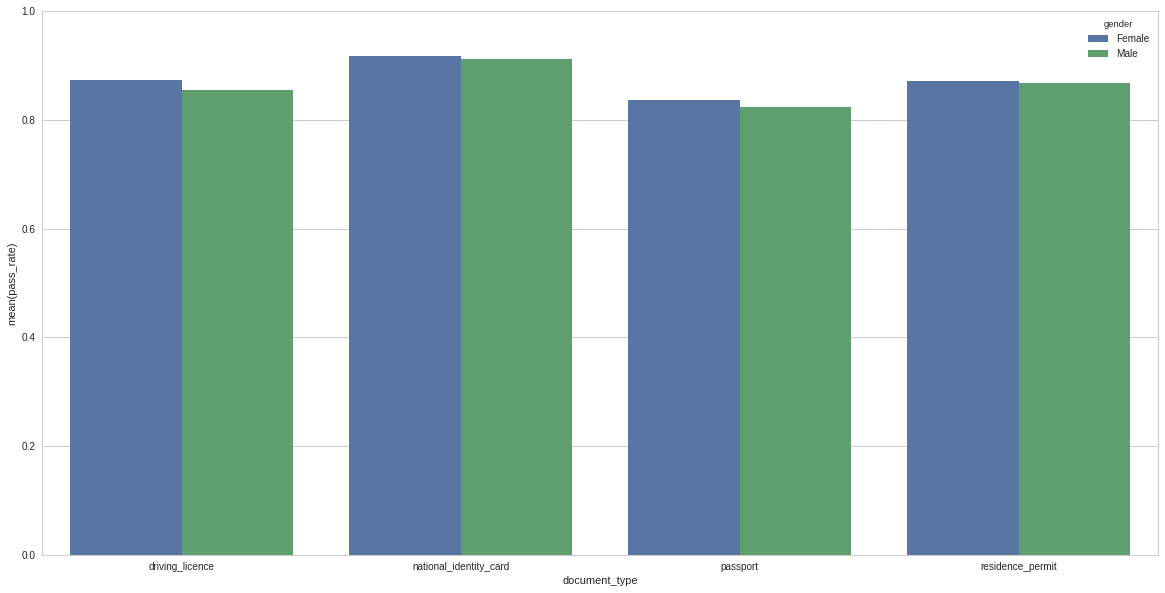

In [0]:


fig,ax = plt.subplots(figsize=(20,10)) 
sns.factorplot(x='document_type', y='pass_rate', hue='gender', data=gen_pass_rate, kind='bar',ax=ax)

ax.set_ylim(0,1)
plt.clf()


In [0]:
joined.head()

,index_x,user_id,face_result,face_comparison_result,created_at_x,facial_image_integrity_result,visual_authenticity_result_x,properties_x,attempt_id_x,index_y,...,properties_y,sub_result,date_of_expiry,document_type,document_version,gender,issuing_country,issuing_date,issuing_state,nationality
0,58,ecee468d4a124a8eafeec61271cd0da1,clear,clear,2017-06-20 17:50:43,clear,clear,{},9e4277fc1ddf4a059da3dd2db35f6c76,58,...,"{'document_type': 'driving_licence', 'date_of_...",clear,2021-10-26,driving_licence,NaN,NaN,ITA,NaN,NaN,NaN
1,76,1895d2b1782740bb8503b9bf3edf1ead,clear,clear,2017-06-20 13:28:00,clear,clear,{},ab259d3cb33b4711b0a5174e4de1d72c,76,...,"{'gender': 'Female', 'document_type': 'driving...",clear,2022-01-17,driving_licence,NaN,Female,GBR,NaN,NaN,NaN
2,217,e71b27ea145249878b10f5b3f1fb4317,clear,clear,2017-06-18 21:18:31,clear,clear,{},2b7f1c6f3fc5416286d9f1c97b15e8f9,217,...,"{'gender': 'Male', 'nationality': 'ITA', 'docu...",clear,2019-12-03,passport,NaN,Male,ITA,NaN,NaN,ITA
3,221,f512dc74bd1b4c109d9bd2981518a9f8,clear,clear,2017-06-18 22:17:29,clear,clear,{},ab5989375b514968b2ff2b21095ed1ef,221,...,"{'document_type': 'driving_licence', 'date_of_...",clear,2025-09-18,driving_licence,NaN,NaN,IRL,NaN,NaN,NaN
4,251,0685c7945d1349b7a954e1a0869bae4b,clear,clear,2017-06-18 19:54:21,clear,clear,{},dd1b0b2dbe234f4cb747cc054de2fdd3,251,...,"{'gender': 'Female', 'document_type': 'driving...",clear,2025-03-05,driving_licence,NaN,Female,GBR,NaN,NaN,NaN


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


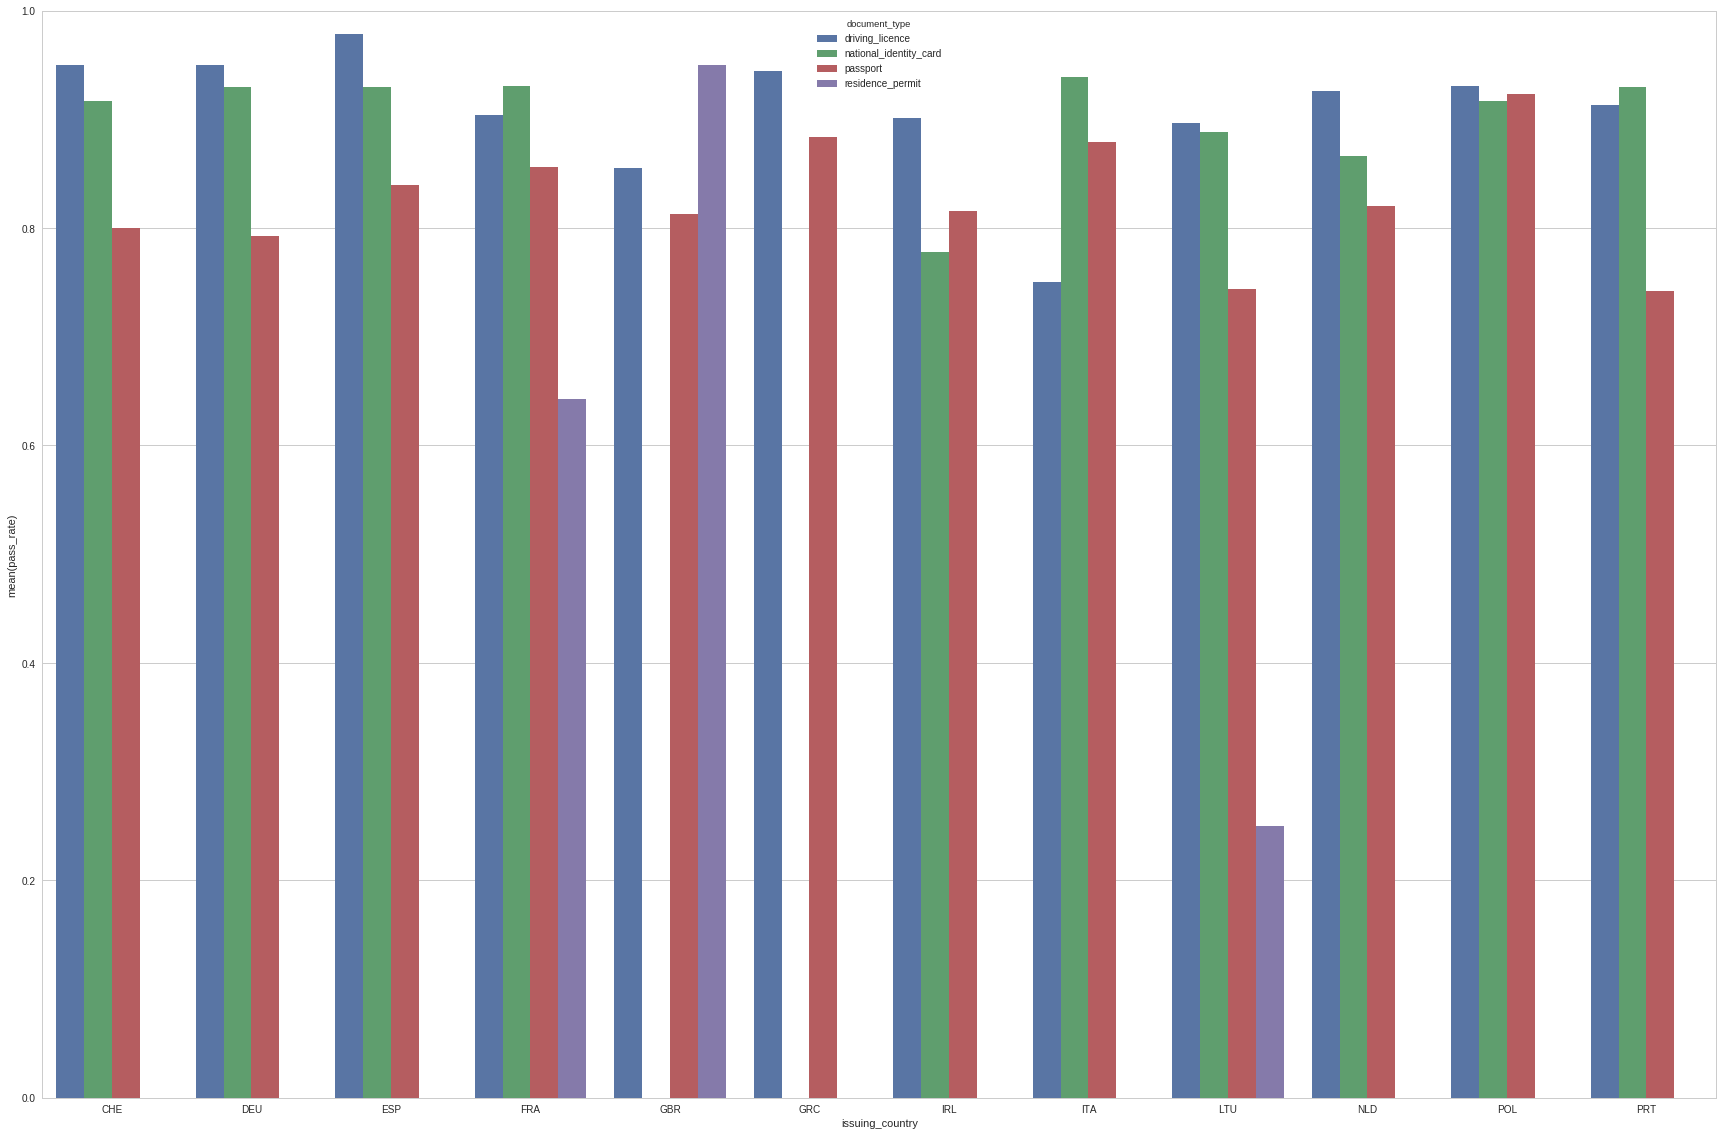

In [0]:
joined_count=joined.groupby('issuing_country').count()

top_countries = list(joined_count[joined_count.user_id > np.mean(joined_count.user_id)]['user_id'].index) # select countries who's number of applicants exceeds the average number of applicants per country

key_countries= joined[joined['issuing_country'].isin(top_countries)]

doc_type_count = pd.pivot_table(key_countries,columns=['doc_result'],values=['user_id'],index=['document_type','issuing_country'],aggfunc='count')
doc_type_count_pass = get_pass_rate(remove_multiindex(doc_type_count)).reset_index()

doc_type_count_pass


fig,ax = plt.subplots(figsize=(30,20)) 

sns.factorplot(x='issuing_country', y='pass_rate', hue='document_type', data=doc_type_count_pass, kind='bar',ax=ax)
ax.set_ylim(0,1)
plt.clf()



Passport seems to be causing issues across the board, with generally the lowest pass rate. There is significant variation across the top countries

LTU and FRA has especially low pass rates for resident permit based ID

In [0]:
joined.fillna('null',inplace=True)
joined['face_result'].unique()

array(['clear', 'consider'], dtype=object)

In [0]:
face_or_doc_consider = joined[(joined.face_result=='consider')|(joined.doc_result=='consider')].dropna()

face_and_doc_consider = joined[(joined.face_result=='consider')&(joined.doc_result=='consider')].dropna()

print('There are {} users who failed either face or document verification'.format(str(len(face_or_doc_consider))))

print('There are {} users who failed both face and document verification'.format(str(len(face_and_doc_consider))))


There are 1688 users who failed either face or document verification
There are 197 users who failed both face and document verification


##What were the main points of failure in verification?



In [0]:


df_melt_values = [col for col in face_or_doc_consider.columns if 'result' in col]

m = pd.melt(face_or_doc_consider, id_vars=['user_id'], var_name='result_type',value_vars =df_melt_values)



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


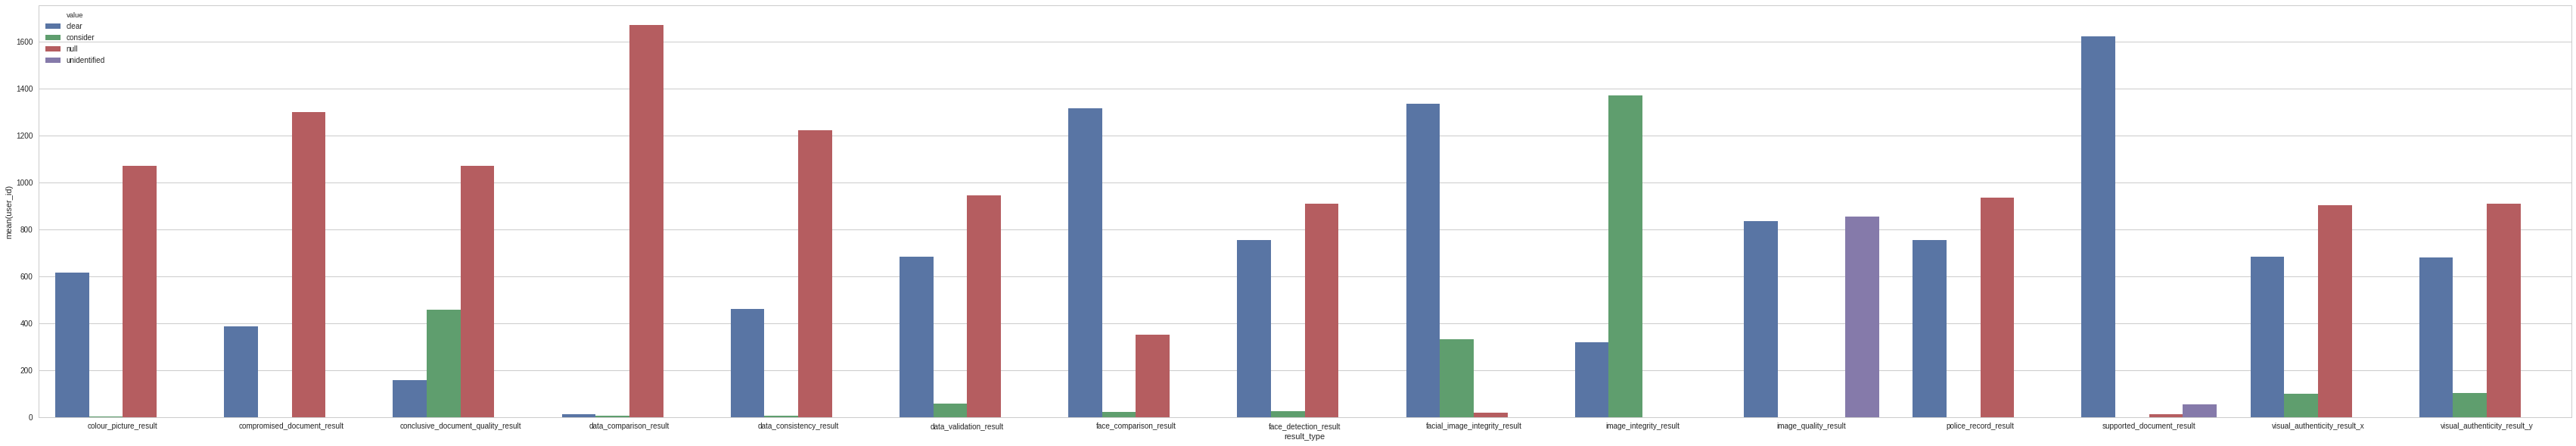

In [0]:
plot_df_grouped = m.groupby(['result_type',"value"]).count().reset_index()


plot_df_grouped = plot_df_grouped[~plot_df_grouped['result_type'].isin(['sub_result',"face_result","doc_result"])]



fig,ax = plt.subplots(figsize=(60,10)) 

sns.factorplot(x='result_type', y='user_id', hue='value', data=plot_df_grouped, kind='bar',ax=ax)
plt.clf()


There seems to be a significant issue around image integrity as well as conclusive document quality but to a lesser extent. Also there are a large number of unidentified cases for image quality